In [1]:
import wandb
from datetime import datetime

In [2]:
mask_model_ver = 132508
lr = 1e-3
batch_size = 16
wd = 1e-5
IMAGE_SIZE = 512
backbone='efficientdetv2_ds'
vertical_type = "axial"
train_portion = 0.5
milestones = [10,20,30,40]
model_name = "effdet"
epochs =100

checkpoint = 'axial_detection_effdet_134352-epoch-52.pth'

In [3]:
wandb_entity='longyi'
model_name = "effdet"
wandb.init(project="YOLOR", entity=wandb_entity, config={
    "model":model_name,
    "batch_size":batch_size,
    "lr" : lr,
    "wd" : wd,
    "backbone" : backbone,
    "image_size" : IMAGE_SIZE,
})
wandb.run.name = f'axial_detection_{model_name}_' + datetime.now().strftime("%H%M%S")
wandb.run.name

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: longyi. Use `wandb login --relogin` to force relogin


'axial_detection_effdet_135654'

In [4]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import sys

effdet_path = "../third/effdet"
sys.path.append(effdet_path)
timm_path = "../third/timm-pytorch-image-models"
sys.path.append(timm_path)
import timm
from timm.data import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD
from matplotlib import patches
import sklearn
import os
from tqdm import tqdm

omega_path = "../third/omegaconf"
sys.path.append(omega_path)
from omegaconf import OmegaConf
import glob
import sklearn
import math
import random

from PIL import Image

import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch import optim
import torchvision.transforms as T
import torchvision.transforms.functional as TF

from effdet import create_model
from effdet import DetBenchPredict
# from transformers import get_cosine_schedule_with_warmup

import warnings

warnings.filterwarnings('ignore')
from sklearn import metrics, model_selection, preprocessing

# from sklearn.model_selection import GroupKFold

%load_ext autoreload
%autoreload 2

# pos_weight = torch.tensor(pos_weight)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [5]:
DATA_DIR = "/root/autodl-tmp/cervical_spine/"
IMAGES_DIR = os.path.join(DATA_DIR, 'train_axial_images_jpeg95_croped_132508')
MASK_DIR = os.path.join(DATA_DIR, f'segmentation_axial_results_{mask_model_ver}')

In [6]:

total_boundary_df = pd.read_csv(os.path.join(DATA_DIR, f'infered_boundary_{mask_model_ver}_2.csv'))
total_boundary_df['UID_Slice'] = total_boundary_df['StudyInstanceUID'] + '.' + total_boundary_df['Slice'].astype('string')
total_boundary_df = total_boundary_df.set_index('UID_Slice').astype({'Slice': int})
print(len(total_boundary_df))
total_boundary_df.head()

708779


,StudyInstanceUID,Slice,Start,pixel_spacing,xmin,ymin,xmax,ymax
UID_Slice,,,,,,,,
1.2.826.0.1.3680043.10001.0,1.2.826.0.1.3680043.10001,0,0,0.253906,0.0,0.0,512.0,512.0
1.2.826.0.1.3680043.10001.1,1.2.826.0.1.3680043.10001,1,0,0.253906,0.0,0.0,512.0,512.0
1.2.826.0.1.3680043.10001.2,1.2.826.0.1.3680043.10001,2,0,0.253906,0.0,0.0,512.0,512.0
1.2.826.0.1.3680043.10001.3,1.2.826.0.1.3680043.10001,3,0,0.253906,0.0,0.0,512.0,512.0
1.2.826.0.1.3680043.10001.4,1.2.826.0.1.3680043.10001,4,0,0.253906,0.0,0.0,512.0,512.0


In [7]:
bbox_df = pd.read_csv(os.path.join(DATA_DIR, 'bbox_clean.csv'))
bbox_df['UID_Slice'] = bbox_df['UID'] + '.' + bbox_df['axial_index'].astype('string')
bbox_df = bbox_df.set_index('UID_Slice')

bbox_df = bbox_df.loc[bbox_df.index.isin(total_boundary_df.index)]
print(len(bbox_df))
bbox_df.head()

7203


,UID,start_slice_number,axial_index,coronal_index,sagittal_index,aspect,pixel_spacing,z_spacing,is_flip,num_slices,x,y,width,height,slice_number
UID_Slice,,,,,,,,,,,,,,,
1.2.826.0.1.3680043.10051.132,1.2.826.0.1.3680043.10051,1,132,226,227,2.461541,0.253906,0.625,0.0,272,219.27715,216.71419,17.30440,20.38517,133
1.2.826.0.1.3680043.10051.133,1.2.826.0.1.3680043.10051,1,133,229,230,2.461541,0.253906,0.625,0.0,272,221.56460,216.71419,17.87844,25.24362,134
1.2.826.0.1.3680043.10051.134,1.2.826.0.1.3680043.10051,1,134,234,230,2.461541,0.253906,0.625,0.0,272,216.82151,221.62546,27.00959,26.37454,135
1.2.826.0.1.3680043.10051.135,1.2.826.0.1.3680043.10051,1,135,234,228,2.461541,0.253906,0.625,0.0,272,214.49455,215.48637,27.92726,37.51363,136
1.2.826.0.1.3680043.10051.136,1.2.826.0.1.3680043.10051,1,136,237,227,2.461541,0.253906,0.625,0.0,272,214.00000,215.48637,27.00000,43.51363,137


In [8]:
boundary_df = total_boundary_df[total_boundary_df.StudyInstanceUID.isin(bbox_df.UID.unique())]
print(len(boundary_df))
boundary_df.head()

77339


,StudyInstanceUID,Slice,Start,pixel_spacing,xmin,ymin,xmax,ymax
UID_Slice,,,,,,,,
1.2.826.0.1.3680043.10051.0,1.2.826.0.1.3680043.10051,0,0,0.253906,0.0,0.0,512.0,512.0
1.2.826.0.1.3680043.10051.1,1.2.826.0.1.3680043.10051,1,0,0.253906,0.0,0.0,512.0,512.0
1.2.826.0.1.3680043.10051.2,1.2.826.0.1.3680043.10051,2,0,0.253906,0.0,0.0,512.0,512.0
1.2.826.0.1.3680043.10051.3,1.2.826.0.1.3680043.10051,3,0,0.253906,0.0,0.0,512.0,512.0
1.2.826.0.1.3680043.10051.4,1.2.826.0.1.3680043.10051,4,0,0.253906,0.0,0.0,512.0,512.0


Pick useful columns

In [9]:
train_df = pd.concat((bbox_df[['x','y','width','height']], boundary_df[['xmin','ymin','xmax','ymax','Slice', 'StudyInstanceUID']]), axis=1)
train_df[['new_x', 'new_y']] = train_df[['x','y']].values - train_df[['xmin','ymin']].values
print(len(train_df))
train_df.head()

77339


,x,y,width,height,xmin,ymin,xmax,ymax,Slice,StudyInstanceUID,new_x,new_y
UID_Slice,,,,,,,,,,,,
1.2.826.0.1.3680043.10051.132,219.27715,216.71419,17.30440,20.38517,43.076729,0.0,436.923271,393.846542,132,1.2.826.0.1.3680043.10051,176.200421,216.71419
1.2.826.0.1.3680043.10051.133,221.56460,216.71419,17.87844,25.24362,36.076729,0.0,429.923271,393.846542,133,1.2.826.0.1.3680043.10051,185.487871,216.71419
1.2.826.0.1.3680043.10051.134,216.82151,221.62546,27.00959,26.37454,45.076729,0.0,438.923271,393.846542,134,1.2.826.0.1.3680043.10051,171.744781,221.62546
1.2.826.0.1.3680043.10051.135,214.49455,215.48637,27.92726,37.51363,41.076729,0.0,434.923271,393.846542,135,1.2.826.0.1.3680043.10051,173.417821,215.48637
1.2.826.0.1.3680043.10051.136,214.00000,215.48637,27.00000,43.51363,28.076729,0.0,421.923271,393.846542,136,1.2.826.0.1.3680043.10051,185.923271,215.48637


Only pick same size negative cases

In [10]:
neg_count = len(train_df[train_df['x'].isna()])
neg_count

70136

In [11]:
pos_count = len(train_df[~train_df['x'].isna()])
pos_count

7203

In [12]:
neg_df = train_df[train_df['x'].isna()]
pos_df = train_df[~train_df['x'].isna()]

In [13]:
def crop_image(img:Image, bbox, crop_box):
    """

    :param img:
    :param bbox: [left, top, right, bottom]
    :param crop_box:[left, top, right, bottom]
    :return:
    """
    left, top, right, bottom = crop_box
    img = img.crop(crop_box)
    bbox[0] -= left
    bbox[1] -= top
    bbox[2] -= left
    bbox[3] -= top

    return img, bbox

x                                      69.632
y                                    249.9159
width                                  57.344
height                               39.98988
xmin                                22.209607
ymin                               187.209607
xmax                               245.790393
ymax                               410.790393
Slice                                     297
StudyInstanceUID    1.2.826.0.1.3680043.11401
new_x                               47.422393
new_y                               62.706293
Name: 1.2.826.0.1.3680043.11401.297, dtype: object


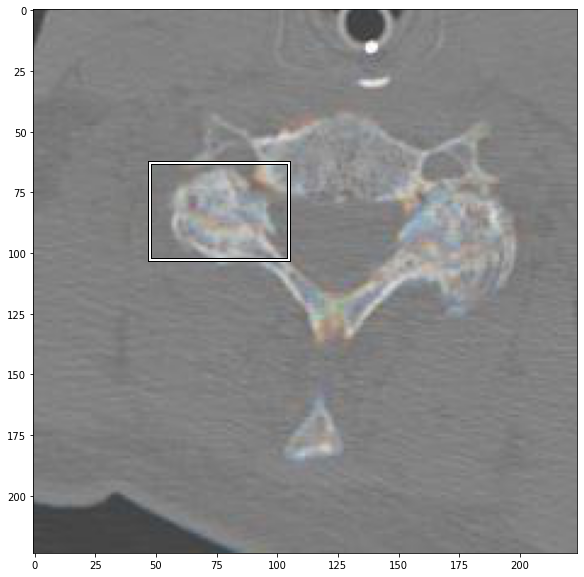

In [14]:
def get_rectangle_edges_from_pascal_bbox(bbox):
    xmin_top_left, ymin_top_left, xmax_bottom_right, ymax_bottom_right = bbox

    width = xmax_bottom_right - xmin_top_left
    height = ymin_top_left - ymax_bottom_right

    return xmin_top_left, ymax_bottom_right, width, height


def draw_pascal_voc_bboxes(
        plot_ax,
        bbox,
        get_rectangle_corners_fn=get_rectangle_edges_from_pascal_bbox,
):
    x, y, width, height = get_rectangle_corners_fn(bbox)

    rect_1 = patches.Rectangle(
        (x, y),
        width,
        height,
        linewidth=4,
        edgecolor="black",
        fill=False,
    )
    rect_2 = patches.Rectangle(
        (x, y),
        width,
        height,
        linewidth=2,
        edgecolor="white",
        fill=False,
    )

    # Add the patch to the Axes
    plot_ax.add_patch(rect_1)
    plot_ax.add_patch(rect_2)


def show_image(
        image, bbox=None, draw_bboxes_fn=draw_pascal_voc_bboxes, figsize=(10, 10)
):
    fig, ax = plt.subplots(1, figsize=figsize)
    ax.imshow(image)

    draw_bboxes_fn(ax, bbox)

    plt.show()


s = pos_df.iloc[269]
print(s)
image = Image.open(os.path.join(IMAGES_DIR, s.StudyInstanceUID, f'{int(s.Slice)}.jpeg'))
bbox = list(s[['new_x', 'new_y','width','height']])
bbox = [bbox[0], bbox[1], bbox[0] + bbox[2], bbox[1] + bbox[3]]
crop_box = s[['xmin','ymin','xmax','ymax']]
show_image(image, bbox)

## Dataset

In [15]:
class FractureDatasetAdaptor(Dataset):
    def __init__(self, images_dir_path, mask_dir, pos_df, neg_df):
        self.image_dir = images_dir_path
        self.mask_dir = mask_dir
        self.pos_df = pos_df
        self.neg_df = neg_df

    def __len__(self) -> int:
        return len(self.pos_df) * 2

    def __getitem__(self, idx):
        
        is_pos = (idx % 2) == 0
        
        if is_pos:
            s = self.pos_df.iloc[idx // 2]
        else:
            rand_idx = np.random.randint(0, len(self.neg_df))
            s = self.neg_df.iloc[rand_idx]
        UID = s.StudyInstanceUID
        # print(s)
        axial_index = int(s.Slice)
        img = Image.open(os.path.join(self.image_dir, UID, f"{axial_index}.jpeg"))
        
        mask = Image.open(os.path.join(self.mask_dir, UID, f'{axial_index}.png'))
        mask = mask.crop((s.xmin/2, s.ymin/2, s.xmax/2, s.ymax/2))
        
        if pd.isna(s.x):
            pascal_bboxes = []
            class_labels = []
        else:
            pascal_bboxes = [[s.new_x, s.new_y, s.new_x + s.width, s.new_y + s.height]]
            class_labels = np.ones(1)

        return img, pascal_bboxes, class_labels, idx

    def show_image(self, index):
        image, bboxes, class_labels, image_id = self.get_image_and_labels_by_idx(index)
        print(f"image_id: {image_id}")
        show_image(image, bboxes)
        print(class_labels)

da = FractureDatasetAdaptor(IMAGES_DIR, MASK_DIR, pos_df, neg_df)
da[0]

(<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=394x394 at 0x7F67B4B780D0>,
 [[176.20042081675894, 216.71419, 193.50482081675892, 237.09936]],
 array([1.]),
 0)

## Transform

{'bboxes': tensor([[281.6184, 217.5071, 343.8994, 250.1693]]), 'labels': tensor([1.], dtype=torch.float64), 'image_id': tensor([10]), 'img_size': (512, 512), 'img_scale': tensor([1.])}
torch.Size([3, 512, 512])
tensor(-1.) tensor(0.9168)


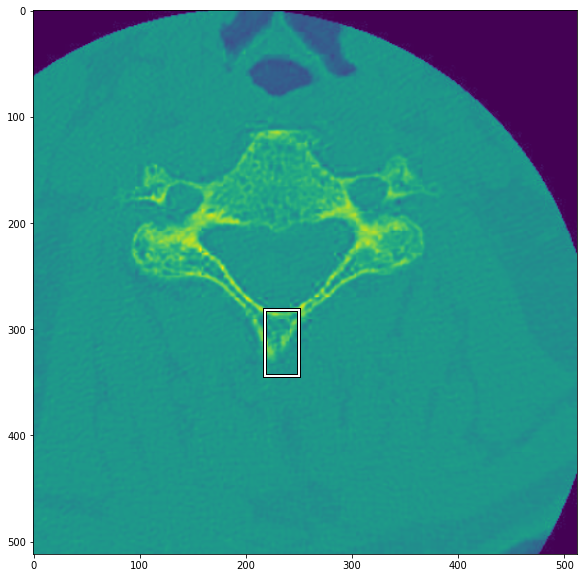

In [16]:
def get_train_transforms(target_img_size=512):
    return A.Compose(
        [
            A.ShiftScaleRotate(p=0.5, rotate_limit=15),
            A.HorizontalFlip(p=0.5),
            A.Resize(height=target_img_size, width=target_img_size, p=1),
            A.Normalize(0.5, 0.5),
            ToTensorV2(p=1),
        ],
        p=1.0,
        bbox_params=A.BboxParams(
            format="pascal_voc", min_area=0, min_visibility=0, label_fields=["labels"]
        ),
    )



class EfficientDetDataset(Dataset):
    def __init__(
            self, dataset_adaptor, transforms=None
    ):
        self.ds = dataset_adaptor
        self.transforms = transforms

    def __getitem__(self, index):
        (
            image,
            pascal_bboxes,
            class_labels,
            image_id
        ) = self.ds[index]

        if len(pascal_bboxes) > 0:
            # image, pascal_bboxes = crop_image(image, pascal_bboxes[0], crop_box)
            pascal_bboxes = pascal_bboxes[0]
            pascal_bboxes[0] = max(0, pascal_bboxes[0])
            pascal_bboxes[1] = max(0, pascal_bboxes[1])
            pascal_bboxes[2] = min(image.width, pascal_bboxes[2])
            pascal_bboxes[3] = min(image.height, pascal_bboxes[3])
            
            sample = {
                "image": np.array(image, dtype=np.float32),
                "bboxes": [pascal_bboxes],
                "labels": class_labels,
            }
            sample = self.transforms(**sample)
            sample["bboxes"] = np.array(sample["bboxes"])
            image = sample["image"]
            labels = sample["labels"]

            # print(sample)

            _, new_h, new_w = image.shape
            if len(sample["bboxes"]) > 0:
                sample["bboxes"][:, [0, 1, 2, 3]] = sample["bboxes"][
                                                :, [1, 0, 3, 2]
                                                ]  # convert to yxyx

                target = {
                    "bboxes": torch.as_tensor(sample["bboxes"], dtype=torch.float32),
                    "labels": torch.as_tensor(labels),
                    "image_id": torch.tensor([image_id]),
                    "img_size": (new_h, new_w),
                    "img_scale": torch.tensor([1.]),
                }
            else:
                target = {
                    "bboxes": torch.zeros((0, 4)),
                    "labels": torch.tensor([]),
                    "image_id": torch.tensor([image_id]),
                    "img_size": (new_h, new_w),
                    "img_scale": torch.tensor([1.]),
                }
        else:
            # image = image.crop(crop_box)   
            image = self.transforms(image=np.array(image, dtype=np.float32), bboxes=[], labels=[])["image"]
            _, new_h, new_w = image.shape
            target = {
                "bboxes": torch.zeros((0, 4)),
                "labels": torch.tensor([]),
                "image_id": torch.tensor([image_id]),
                "img_size": (new_h, new_w),
                "img_scale": torch.tensor([1.]),
            }
        
        

        return image, target, image_id

    def __len__(self):
        return len(self.ds)


train_dataset = EfficientDetDataset(da, transforms=get_train_transforms(IMAGE_SIZE))
img, ann, idx = train_dataset[10]
print(ann)
print(img.shape)
print(img.min(), img.max())
fig, ax = plt.subplots(1, figsize=(10, 10))
ax.imshow(img[2, :, :])

if len(ann['bboxes']) > 0:
    draw_pascal_voc_bboxes(ax, ann['bboxes'][0].cpu().numpy()[[1, 0, 3, 2]])


In [17]:
def collate_fn(batch):
    images, targets, image_ids = tuple(zip(*batch))
    images = torch.stack(images)
    images = images.float()

    boxes = [target["bboxes"].float() for target in targets]
    labels = [target["labels"].float() for target in targets]
    img_size = torch.tensor([target["img_size"] for target in targets]).float()
    img_scale = torch.tensor([target["img_scale"] for target in targets]).float()

    annotations = {
        "bbox": boxes,
        "cls": labels,
        "img_size": img_size,
        "img_scale": img_scale,
    }

    return images, annotations, targets, image_ids

In [18]:
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    pin_memory=True,
    drop_last=True,
    num_workers=min(os.cpu_count(), 16),
    collate_fn=collate_fn,
)

## Model

In [19]:
# from effdet.config.model_config import efficientdet_model_param_dict
# list(efficientdet_model_param_dict.keys())

In [20]:


def get_det_model(image_size, checkpoint=None):
    if checkpoint is None:

        model = create_model(backbone , bench_task='train' , num_classes= 1 , image_size=(image_size, image_size), bench_labeler=True, pretrained=True)
        model = model.to(device)
        return model
    else:
        model = create_model(backbone , bench_task='train' , num_classes= 1 , image_size=(image_size, image_size), bench_labeler=True, pretrained=True)
        state = torch.load(os.path.join(DATA_DIR, 'checkpoint', checkpoint), map_location=torch.device(device))
        model.load_state_dict(state["model"])
        model = model.to(device)
        return model

model = get_det_model(IMAGE_SIZE, checkpoint)
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(total_params)

26374778


In [21]:
# class_out, box_out = model.model(img.unsqueeze(0).to(device))
# anchors = Anchors.from_config(model.model.config).to(device)
# decode_model_outputs(class_out, box_out, anchors, model.model.config.num_levels)

In [22]:
# val_model = DetBenchPredict(model.model).to(device)
# val_model(img.unsqueeze(0).to(device))

In [23]:
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=wd)
scaler = torch.cuda.amp.GradScaler(enabled=(device == 'cuda'))
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=0.5)
# scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)

In [24]:
from evaluate import *
# evaluator = Evaluate(model.model, save_dir=os.path.join(DATA_DIR, 'predictions', wandb.run.name))

# evaluator.evaluate(59)

## Train one epoch

In [25]:
def train_one_epoch(e, model, dataloader):
    model.train()
    train_iter = tqdm(dataloader)
    loss_list = []
    epoch_iteration = len(dataloader)

    for i, (images, anns, _, _) in enumerate(train_iter):
        images = images.to(device)
        anns = {
            'bbox' : [tensor.to(device) for tensor in anns['bbox']],
            'cls' : [tensor.to(device) for tensor in anns['cls']],
            'img_size' : anns['img_size'].to(device),
            'img_scale' : anns['img_scale'].to(device)
        }

        with torch.cuda.amp.autocast(device == 'cuda'):
            losses = model(images, anns)
            loss, class_loss, box_loss = losses['loss'], losses['class_loss'], losses['box_loss']

        optimizer.zero_grad()
        scaler.scale(loss).backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1.)
        scaler.step(optimizer)
        scaler.update()
        
        scheduler.step(e + i / epoch_iteration)

        train_iter.set_description(f"t {e} loss {loss.item():.4f} c {class_loss.item():.4f} b {box_loss.item():.4f}")

        loss_list.append(loss.item())

        if wandb.run is not None:
            lr_logs = {f"last_lr_{i}": float(v) for i, v in enumerate(scheduler.get_last_lr())}
            wandb.log({
                'train_loss': loss.item(),
                'train_class_loss': class_loss.item(),
                'train_box_loss': box_loss.item(),
                'epoch': e,
                'train_iteration': i + e * epoch_iteration,
                **lr_logs,
            })
            
        
#         if (i + e * epoch_iteration) % 100 == 0:
#             # val_model = DetBenchPredict(model.model).to(device)
#             val_model.eval()
#             val_index = (e * epoch_iteration + i) // 100
#             prediction = evaluate(e, val_model, val_index=val_index)
            
#             model.train()

    return np.mean(loss_list)

In [26]:
# val_UIDs = list(val_df.index.unique())
# len(val_UIDs)

In [27]:
class ValidationDataSet(torch.utils.data.Dataset):
    def __init__(self, df, path, mask_path, transforms=None):
        super().__init__()
        self.df = df
        self.path = path
        self.mask_path = mask_path
        self.transforms = transforms

        self.len = len(self.df)

    def __getitem__(self, i):

        try:
            s = self.df.iloc[i]
            UID = s.name
            img = Image.open(os.path.join(self.path, UID, f'{int(s.Slice)}.jpeg'))

            mask = Image.open(os.path.join(self.mask_path, UID, f'{int(s.Slice)}.png'))
            
            if self.transforms is not None:
                img, mask = self.transforms(img, mask)
        except Exception as ex:
            print(ex)
            return None, None

        return img, s.pixel_spacing, s.Slice == s.Start, s[['xmin','ymin','xmax','ymax']].values, mask

    def __len__(self):
        return self.len

class ValidationTransform(nn.Module):
    def __init__(self, image_size=512):
        super().__init__()

        self.image_size = image_size

        self.transform = T.Compose([
            T.Resize((image_size, image_size)),
            T.ToTensor(),
            T.Normalize(0.5, 0.5),
        ])
        
        self.mask_transform = T.Compose([
            T.ToTensor(),
        ])

    def forward(self, x, mask):
        x = self.transform(x)
        mask = self.mask_transform(mask)
        return x, mask
    
# val_tf = ValidationTransform(IMAGE_SIZE)

# UID = '1.2.826.0.1.3680043.10001'
# evaluate_df = val_df.loc[UID].sort_values('Slice')
# # evaluate_df.iloc[0]
# # print(evaluate_df)
# val_ds = ValidationDataSet(evaluate_df, IMAGES_DIR, MASK_DIR, transforms=val_tf)
# # val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=min(batch_size, 16))

# # iter_d = iter(val_loader)
# # next(iter_d)
# # next(iter_d)
# # next(iter_d)
# img, pixel_spacing, is_end, bbox, mask = val_ds[138]
# print(img.shape, bbox.shape, mask.shape)
# print(mask.min(), mask.max())
# print(bbox)
# _, axs = plt.subplots(1, 2)
# axs[0].imshow(img[0, :, :])
# axs[1].imshow(mask[0, :, :])

In [28]:
def get_bbox_class(seg, bbox):
    """
    label 은 0.125 의 단위로, 
    seg: H x W
    bbox: [xmin, ymin, xmax, ymax]
    """
    xmin, ymin, xmax, ymax = bbox.int()
    area = seg[ymin:ymax, xmin:xmax]
    
    # print(area)
    result = torch.mean(area[area>0])
    result = torch.round(result / 0.125)
    
    return result

In [29]:
def get_bbox_class_list(seg_list, seg_bboxes):
    class_list = []
    for i in range(seg_list.shape[0]):
        class_index = get_bbox_class(seg_list[i, :, :], seg_bboxes[i, :])
        class_list.append(class_index)
        
    return torch.stack(class_list)

In [30]:
# val_df.loc['1.2.826.0.1.3680043.10001'].sort_values('Slice')

In [31]:


def crop_resize_images(imgs_tensor, boundary_list, img_size=512):
    croped_list = []
    for i in range(imgs_tensor.shape[0]):
        xmin, ymin, xmax, ymax = boundary_list[i, :]
        xmin, ymin, xmax, ymax = int(xmin), int(ymin), int(xmax), int(ymax)
        # print(xmin, ymin, xmax, ymax)
        croped = TF.crop(imgs_tensor[i, :, :, :], top=ymin, left=xmin, height=ymax-ymin, width=xmax-xmin)
        croped = TF.resize(croped, (img_size, img_size))
        croped_list.append(croped)
        
    return torch.stack(croped_list, 0)

def predict_det(x, model):
    
    bboxes = model(x) # N x 1 x 6
    
    return bboxes[:, 0, :]

def get_original_bbox(bbox, boundary):
    scale = 512. / (boundary[:, [2]] - boundary[:, [0]])
    
    org_bbox = bbox / scale
    org_bbox[:, 0] += boundary[:, 0]
    org_bbox[:, 1] += boundary[:, 1]
    org_bbox[:, 2] += boundary[:, 0]
    org_bbox[:, 3] += boundary[:, 1]
    
    return org_bbox

def get_class_score(scores, class_list, eps=1e-2):
    result = scores.new_zeros((scores.shape[0], 8)) + eps
    class_list = torch.nan_to_num(class_list).long()
    result[torch.arange(scores.shape[0]), class_list] = scores
    
    return result

def cal_loss(prob, label):
    
    pos_weight = np.array([14, 2, 2, 2, 2, 2, 2, 2])
    neg_weight = np.array([7, 1, 1, 1, 1, 1, 1, 1])
    
    score = pos_weight * label * np.log(prob) + neg_weight * (1 - label) * np.log(1 - prob)
    
    weight_total = pos_weight * label + neg_weight * (1 - label)
    
    return -score.sum() / weight_total.sum()


# table_columns=['UID', 'loss', 'Predictions','Labels']
# evaluate_table = wandb.Table(data=[], columns=table_columns)

def log_prediction(UID, prediction):
    # log
    
    
    label = label_df.loc[UID].values
    loss = cal_loss(prediction, label)
   
    # my_data = [UID, loss, prediction, label]
    
    # evaluate_table.add_data(*my_data)
    
    wandb.run.log({
        # 'evaluate_table' : evaluate_table
        'eval_sample_UID' : int(UID.split('.')[-1]),
        'eval_sample_loss' : loss,
    })
    


def evaluate(e, det_model, UID=None, val_index=None):
    
    if UID is None:
        UID = val_UIDs[val_index]
    
    with torch.no_grad():
        evaluate_df = val_df.loc[UID].sort_values('Slice')
        # print(evaluate_df)
        val_ds = ValidationDataSet(evaluate_df, IMAGES_DIR, MASK_DIR,val_tf)
        val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=min(batch_size, 16))

        predictions = []
        x0 = val_ds[0][0]
        x1 = val_ds[1][0]
        x0, x1 = x0.to(device), x1.to(device)
        prev2 = torch.stack((x0, x1))

        for x, pixel_spacings, is_starts, axial_boundary, seg_result in val_loader:
            x = x.to(device)
            

            # (N+2), 1, 512, 512
            x = torch.cat((prev2, x), dim=0)

            r = x[:-2, :, :, :]
            g = x[1:-1, :, :, :]
            b = x[2:, :, :, :]

            start_indices = torch.argwhere(is_starts)
            r[start_indices, :, :, :] = b[start_indices, :, :, :]
            g[start_indices, :, :, :] = b[start_indices, :, :, :]

            prev2 = b[-2:, :, :, :]

            x = torch.cat((r, g, b), dim=1)

            batch_probs = x.new_zeros((x.shape[0], 8)) + 1e-2

            seg_result = seg_result.to(device)
            # seg_areas = seg_result.count_nonzero(dim=[1, 2, 3]) / (256 * 256)

            # active_indices = torch.argwhere(seg_areas > 0.001)
            active_indices = seg_result.nonzero()[:, 0].unique()

            if active_indices.numel() == 0:
                predictions.append(batch_probs.cpu())
                continue

            axial_boundary, seg_result = axial_boundary.to(device), seg_result.to(device)
            active_indices = active_indices.reshape(-1)

            if active_indices.numel() != batch_size:
                x = x[active_indices, :, :, :]
                seg_result = seg_result[active_indices, :, :, :]
                pixel_spacings = pixel_spacings[active_indices]
                axial_boundary = axial_boundary[active_indices]
                


            # axial_boundary = get_axial_boundary(seg_result, pixel_spacings, seg_img_size=256)  # N x 4, 512 scale

            x = crop_resize_images(x, axial_boundary) # N x 3 x 512 x 512 croped


            # for det_model in det_models:
            det_result = predict_det(x, det_model)
            bboxes, scores = get_original_bbox(det_result[:, :4], axial_boundary), det_result[:, 4]
            class_list = get_bbox_class_list(seg_result[:, 0, :, :], bboxes / 2)
            probs = get_class_score(scores, class_list) # N x 7

            batch_probs[active_indices, :] = probs
            # print(probs)
            predictions.append(batch_probs.cpu())

        predictions = torch.concat(predictions)
      
        # predictions[:, 0] = torch.amax(predictions, dim=1)
        prediction = predictions.amax(dim=0)
        prediction[0] = prediction[1:].amax()
        # print(predictions)
        # return predictions
        
        
        if wandb.run is not None:
            log_prediction(UID, prediction.numpy())
        
        
        return prediction

# val_model = DetBenchPredict(model.model).to(device)
# val_model = val_model.eval()
# prediction = evaluate(0, val_model)
# prediction

In [32]:
def save_state(epoch):
    state = {
        "model": model.state_dict(),
        "optimizer": optimizer.state_dict(),
        "scheduler": scheduler.state_dict(),
        "epoch": epoch,
    }
    torch.save(state, os.path.join(DATA_DIR, f'checkpoint/{wandb.run.name}-epoch-{epoch}.pth'))


In [33]:
epoch = 0


In [34]:
from evaluate import *
evaluator = Evaluate(model.model, save_dir=os.path.join(DATA_DIR, 'predictions', wandb.run.name))

In [35]:
start_batch_index = 0
for i in range(252):
    loss, pos_loss, neg_loss, batch_index = evaluator.evaluate(epoch + i + start_batch_index)
    wandb.log({
        'val/total_loss': loss,
        'val/pos_loss': pos_loss,
        'val/neg_loss': neg_loss,
        'val/batch_index' : batch_index
    })

test df length :  2819


100%|██████████| 177/177 [00:32<00:00,  5.42it/s]


loss :0.6531180457503825 pos_loss:0.12588019215524054 neg_loss:0.6283745990247567
test df length :  2429


100%|██████████| 152/152 [00:25<00:00,  5.87it/s]


loss :0.5405492738230384 pos_loss:0.27684518331065805 neg_loss:0.3923200436031765
test df length :  3430


100%|██████████| 215/215 [00:35<00:00,  6.04it/s]


loss :0.2788544568607351 pos_loss:0.2333834710807703 neg_loss:0.17400098032264943
test df length :  2621


100%|██████████| 164/164 [00:27<00:00,  5.86it/s]


loss :0.625027263988316 pos_loss:0.32783344301950357 neg_loss:0.45843723205004555
test df length :  2048


100%|██████████| 128/128 [00:22<00:00,  5.59it/s]


loss :0.1912095425794571 pos_loss:0.03147433351632403 neg_loss:0.5537274832524063
test df length :  2473


100%|██████████| 155/155 [00:27<00:00,  5.74it/s]


loss :0.47311678764879234 pos_loss:0.242537542134768 neg_loss:0.29898078437222303
test df length :  3029


100%|██████████| 190/190 [00:32<00:00,  5.78it/s]


loss :0.49739947867975876 pos_loss:0.5109885680939087 neg_loss:0.30190022603938227
test df length :  3187


100%|██████████| 200/200 [00:35<00:00,  5.66it/s]


loss :0.3683514981281145 pos_loss:0.0006331118056154927 neg_loss:0.37546481512799185
test df length :  2721


100%|██████████| 171/171 [00:33<00:00,  5.12it/s]


loss :0.291900796132484 pos_loss:0.23487106902811167 neg_loss:0.20054887958197865
test df length :  2526


100%|██████████| 158/158 [00:28<00:00,  5.47it/s]


loss :0.7212410436162535 pos_loss:0.18769407513362138 neg_loss:0.6474098360708157
test df length :  3001


100%|██████████| 188/188 [00:31<00:00,  5.91it/s]


loss :0.5130332176116918 pos_loss:0.6026121278486012 neg_loss:0.10503776306181141
test df length :  2694


100%|██████████| 169/169 [00:30<00:00,  5.52it/s]


loss :0.8162295615057582 pos_loss:0.7957697271037156 neg_loss:0.3042507330718149
test df length :  2526


100%|██████████| 158/158 [00:28<00:00,  5.60it/s]


loss :0.38272358867268796 pos_loss:0.28949922054683064 neg_loss:0.18769530291096767
test df length :  2659


100%|██████████| 167/167 [00:29<00:00,  5.70it/s]


loss :0.2726729168056225 pos_loss:0.2601922317926372 neg_loss:0.2235041804441345
test df length :  3048


100%|██████████| 191/191 [00:30<00:00,  6.36it/s]


loss :0.2576965998373358 pos_loss:0.028943463697369606 neg_loss:0.3488745586267862
test df length :  3138


100%|██████████| 197/197 [00:33<00:00,  5.92it/s]


loss :0.288937962880271 pos_loss:0.22526331637175484 neg_loss:0.1981386051018278
test df length :  3482


100%|██████████| 218/218 [00:38<00:00,  5.65it/s]


loss :0.3622617727844768 pos_loss:0.09723184677721317 neg_loss:0.4812688089926034
test df length :  3003


100%|██████████| 188/188 [00:30<00:00,  6.20it/s]


loss :0.1798375296028224 pos_loss:0.04024073113466008 neg_loss:0.23918191463832972
test df length :  2556


100%|██████████| 160/160 [00:28<00:00,  5.58it/s]


loss :0.7110357613508416 pos_loss:0.7559779590493099 neg_loss:0.3575417405966632
test df length :  3294


100%|██████████| 206/206 [00:34<00:00,  5.93it/s]


loss :0.5826415627160678 pos_loss:0.5112027413823584 neg_loss:0.223728475863897
test df length :  2654


100%|██████████| 166/166 [00:28<00:00,  5.77it/s]


loss :0.2887765476783819 pos_loss:0.269627109982823 neg_loss:0.10735122630051096
test df length :  3168


100%|██████████| 198/198 [00:32<00:00,  6.03it/s]


loss :0.578482740100845 pos_loss:0.6098429065644799 neg_loss:0.17373040328303443
test df length :  2911


100%|██████████| 182/182 [00:30<00:00,  5.90it/s]


loss :0.21487112002861164 pos_loss:0.01679536448081729 neg_loss:0.4779722261583571
test df length :  2431


100%|██████████| 152/152 [00:28<00:00,  5.42it/s]


loss :0.23461143158485445 pos_loss:0.016255431460128353 neg_loss:0.31900921180525754
test df length :  2521


100%|██████████| 158/158 [00:29<00:00,  5.45it/s]


loss :0.1864618589257362 pos_loss:0.007756407573255133 neg_loss:0.1924055249909976
test df length :  2531


100%|██████████| 159/159 [00:27<00:00,  5.80it/s]


loss :0.44649194815685295 pos_loss:0.31301637821872513 neg_loss:0.25087790000160326
test df length :  2819


100%|██████████| 177/177 [00:29<00:00,  6.06it/s]


loss :0.1257473165531998 pos_loss:0.03266259285903183 neg_loss:0.12711375742197345
test df length :  2699


100%|██████████| 169/169 [00:27<00:00,  6.04it/s]


loss :0.623132167937675 pos_loss:0.43066124305113485 neg_loss:0.46525984473862503
test df length :  2750


100%|██████████| 172/172 [00:28<00:00,  5.97it/s]


loss :0.11565881886586278 pos_loss:0.03207270586905405 neg_loss:0.26725474871448884
test df length :  3611


100%|██████████| 226/226 [00:39<00:00,  5.73it/s]


loss :0.35052452152882185 pos_loss:0.29423259406374247 neg_loss:0.19681015825531228
test df length :  2467


100%|██████████| 155/155 [00:26<00:00,  5.91it/s]


loss :0.5652103123639554 pos_loss:0.34789427636768183 neg_loss:0.36941576282394867
test df length :  2869


100%|██████████| 180/180 [00:30<00:00,  5.87it/s]


loss :0.5009699290154743 pos_loss:0.3642579762283959 neg_loss:0.29895561335158327
test df length :  2931


100%|██████████| 184/184 [00:30<00:00,  6.07it/s]


loss :0.4467074574914749 pos_loss:0.18323245550291936 neg_loss:0.3482658194660195
test df length :  2808


100%|██████████| 176/176 [00:31<00:00,  5.51it/s]


loss :0.5716953064343089 pos_loss:0.0903353272987378 neg_loss:0.5758936923208001
test df length :  2640


100%|██████████| 165/165 [00:29<00:00,  5.66it/s]


loss :0.6587178558529331 pos_loss:0.31715592470154413 neg_loss:0.510548698721221
test df length :  3371


100%|██████████| 211/211 [00:34<00:00,  6.04it/s]


loss :0.0961712799751187 pos_loss:0.030061761177457298 neg_loss:0.12409487097075078
test df length :  3333


100%|██████████| 209/209 [00:34<00:00,  6.08it/s]


loss :0.3383677701472293 pos_loss:0.2401350392915523 neg_loss:0.20143126533892233
test df length :  2277


100%|██████████| 143/143 [00:28<00:00,  5.05it/s]


loss :0.3896197088413521 pos_loss:0.08403729198103521 neg_loss:0.4503457812059176
test df length :  2612


100%|██████████| 164/164 [00:29<00:00,  5.53it/s]


loss :0.6471616672115423 pos_loss:0.5960075595746598 neg_loss:0.4507067977134136
test df length :  2907


100%|██████████| 182/182 [00:31<00:00,  5.77it/s]


loss :0.4242097622706589 pos_loss:0.3996698778207124 neg_loss:0.1607690694018512
test df length :  3131


100%|██████████| 196/196 [00:32<00:00,  6.01it/s]


loss :0.37908176313257036 pos_loss:0.1940093684005916 neg_loss:0.41445436885149195
test df length :  3348


100%|██████████| 210/210 [00:34<00:00,  6.13it/s]


loss :0.35948270620299744 pos_loss:0.15142984125907297 neg_loss:0.37674662052234853
test df length :  3648


100%|██████████| 228/228 [00:39<00:00,  5.81it/s]


loss :0.18885131097586172 pos_loss:0.00263528036868493 neg_loss:0.19030610269328205
test df length :  3176


100%|██████████| 199/199 [00:32<00:00,  6.12it/s]


loss :0.2927785253442534 pos_loss:0.11024884972032283 neg_loss:0.23754364649205284
test df length :  2493


100%|██████████| 156/156 [00:30<00:00,  5.19it/s]


loss :0.25988110230035844 pos_loss:0.26258424739861796 neg_loss:0.1553536121265895
test df length :  2155


100%|██████████| 135/135 [00:24<00:00,  5.57it/s]


loss :0.2741314186955307 pos_loss:0.23659514787252015 neg_loss:0.2637826468932567
test df length :  2924


100%|██████████| 183/183 [00:28<00:00,  6.37it/s]


loss :0.6066395293203571 pos_loss:0.3203638136691514 neg_loss:0.5086590834643516
test df length :  3051


100%|██████████| 191/191 [00:33<00:00,  5.74it/s]


loss :0.4116288867600213 pos_loss:0.3778620775967925 neg_loss:0.1564786663210851
test df length :  3400


100%|██████████| 213/213 [00:34<00:00,  6.16it/s]


loss :0.5266971336352615 pos_loss:0.15362740493350685 neg_loss:0.42818939752716273
test df length :  2781


100%|██████████| 174/174 [00:30<00:00,  5.64it/s]


loss :0.36747631753933907 pos_loss:0.20957798336401473 neg_loss:0.2504029043605015
test df length :  3374


100%|██████████| 211/211 [00:35<00:00,  5.86it/s]


loss :0.3149653926984864 pos_loss:0.2004967312246948 neg_loss:0.3475613733591883
test df length :  3081


100%|██████████| 193/193 [00:32<00:00,  5.87it/s]


loss :0.3000814754488672 pos_loss:0.13953102984524912 neg_loss:0.2743743772578273
test df length :  3143


100%|██████████| 197/197 [00:31<00:00,  6.31it/s]


loss :0.38588190013507273 pos_loss:0.31662722245577346 neg_loss:0.18794305785615995
test df length :  2694


100%|██████████| 169/169 [00:27<00:00,  6.07it/s]


loss :0.4519174434571003 pos_loss:0.08891232135265673 neg_loss:0.41660863469630893
test df length :  2647


100%|██████████| 166/166 [00:27<00:00,  6.07it/s]


loss :0.23595063623748477 pos_loss:0.22285980885561474 neg_loss:0.08442370253539092
test df length :  2542


100%|██████████| 159/159 [00:27<00:00,  5.69it/s]


loss :0.4071607432540576 pos_loss:0.15257858774741503 neg_loss:0.3689190576911039
test df length :  2863


100%|██████████| 179/179 [00:30<00:00,  5.78it/s]


loss :0.23800908540110627 pos_loss:0.20362892105841723 neg_loss:0.12636164033903258
test df length :  2231


100%|██████████| 140/140 [00:26<00:00,  5.31it/s]


loss :0.33549375834452216 pos_loss:0.06544972092055269 neg_loss:0.37545261217952985
test df length :  2456


100%|██████████| 154/154 [00:28<00:00,  5.50it/s]


loss :0.3033339897247769 pos_loss:0.0008626850903426355 neg_loss:0.3079874507961288
test df length :  3110


100%|██████████| 195/195 [00:32<00:00,  5.93it/s]


loss :0.2515355360646967 pos_loss:0.16242118103871542 neg_loss:0.27803030751631314
test df length :  2443


100%|██████████| 153/153 [00:28<00:00,  5.46it/s]


loss :0.13984579320822016 pos_loss:0.09353691457035658 neg_loss:0.11695484858256455
test df length :  2646


100%|██████████| 166/166 [00:29<00:00,  5.71it/s]


loss :0.2764290790308902 pos_loss:0.19112505387493103 neg_loss:0.24524269509893998
test df length :  3181


100%|██████████| 199/199 [00:32<00:00,  6.13it/s]


loss :0.563423903896451 pos_loss:0.4641721273800471 neg_loss:0.28441964922821916
test df length :  2323


100%|██████████| 146/146 [00:26<00:00,  5.53it/s]


loss :0.6740388614493991 pos_loss:0.5060807371250207 neg_loss:0.40891318890508455
test df length :  3020


100%|██████████| 189/189 [00:31<00:00,  6.03it/s]


loss :0.39823428011429796 pos_loss:0.3809008307051269 neg_loss:0.15178901078967777
test df length :  2539


100%|██████████| 159/159 [00:29<00:00,  5.37it/s]


loss :0.6005766727315948 pos_loss:0.28970985308490604 neg_loss:0.45107796552527235
test df length :  2618


100%|██████████| 164/164 [00:28<00:00,  5.69it/s]


loss :0.2813140757426511 pos_loss:0.25881651106576764 neg_loss:0.21489729659902926
test df length :  2905


100%|██████████| 182/182 [00:32<00:00,  5.57it/s]


loss :0.33100957856877067 pos_loss:0.09944014742795368 neg_loss:0.29222179172571894
test df length :  2084


100%|██████████| 131/131 [00:26<00:00,  5.01it/s]


loss :0.33545462269783505 pos_loss:0.07478757644536074 neg_loss:0.36620723781702647
test df length :  3213


100%|██████████| 201/201 [00:34<00:00,  5.82it/s]


loss :0.3200895807769319 pos_loss:0.07747726700715775 neg_loss:0.28412136972603413
test df length :  2637


100%|██████████| 165/165 [00:30<00:00,  5.46it/s]


loss :0.19311906987767538 pos_loss:0.12410847107871391 neg_loss:0.18787637766002346
test df length :  2911


100%|██████████| 182/182 [00:31<00:00,  5.76it/s]


loss :0.1602754113854018 pos_loss:0.06046333419712481 neg_loss:0.13170604253087492
test df length :  2732


100%|██████████| 171/171 [00:29<00:00,  5.71it/s]


loss :0.2705869283040374 pos_loss:0.165638530745986 neg_loss:0.23607187578112254
test df length :  3081


100%|██████████| 193/193 [00:32<00:00,  5.85it/s]


loss :0.4538708719163479 pos_loss:0.33313134113973275 neg_loss:0.30958794902577563
test df length :  2898


100%|██████████| 182/182 [00:30<00:00,  6.01it/s]


loss :0.5258768123258964 pos_loss:0.29063415339301335 neg_loss:0.37872168322735056
test df length :  2975


100%|██████████| 186/186 [00:32<00:00,  5.73it/s]


loss :0.21339355655208297 pos_loss:0.0959879005942491 neg_loss:0.29003809252801915
test df length :  3123


100%|██████████| 196/196 [00:34<00:00,  5.67it/s]


loss :0.19934805201792893 pos_loss:0.03239423909487767 neg_loss:0.30264564616652084
test df length :  3345


100%|██████████| 210/210 [00:37<00:00,  5.67it/s]


loss :0.4901519438619823 pos_loss:0.4574314848728887 neg_loss:0.21889621710242907
test df length :  3023


100%|██████████| 189/189 [00:29<00:00,  6.37it/s]


loss :0.37408035078657453 pos_loss:0.0021940041332065715 neg_loss:0.3869475031092662
test df length :  2438


100%|██████████| 153/153 [00:27<00:00,  5.47it/s]


loss :0.3310317282236859 pos_loss:0.03908086148777728 neg_loss:0.38638801149038493
test df length :  2996


100%|██████████| 188/188 [00:37<00:00,  5.08it/s]


loss :0.470621214876232 pos_loss:0.18615900619191217 neg_loss:0.42331037842959246
test df length :  2162


100%|██████████| 136/136 [00:25<00:00,  5.43it/s]


loss :0.4002103764819913 pos_loss:0.20359602857211861 neg_loss:0.3495324637181054
test df length :  3255


100%|██████████| 204/204 [00:34<00:00,  5.93it/s]


loss :0.6783295227544804 pos_loss:0.446886805790597 neg_loss:0.5339577205319553
test df length :  2700


100%|██████████| 169/169 [00:30<00:00,  5.60it/s]


loss :0.4803820903834688 pos_loss:0.42301618267950614 neg_loss:0.23405893517392834
test df length :  3173


100%|██████████| 199/199 [00:35<00:00,  5.67it/s]


loss :0.5641945171127406 pos_loss:0.08789645942697467 neg_loss:0.5794886305036568
test df length :  2139


100%|██████████| 134/134 [00:25<00:00,  5.34it/s]


loss :0.19540888385114275 pos_loss:0.1847392526080213 neg_loss:0.11800109840662515
test df length :  2647


100%|██████████| 166/166 [00:28<00:00,  5.75it/s]


loss :0.5354914672562381 pos_loss:0.40762387027278996 neg_loss:0.2852288987084742
test df length :  2186


100%|██████████| 137/137 [00:23<00:00,  5.79it/s]


loss :0.21671691521179753 pos_loss:0.07825292436848258 neg_loss:0.25889397156604144
test df length :  2921


100%|██████████| 183/183 [00:31<00:00,  5.82it/s]


loss :0.19149713227888204 pos_loss:0.11676769050971032 neg_loss:0.12644190785775267
test df length :  2493


100%|██████████| 156/156 [00:28<00:00,  5.54it/s]


loss :0.5607749707468999 pos_loss:0.46555504524095076 neg_loss:0.30966617543166525
test df length :  2595


100%|██████████| 163/163 [00:28<00:00,  5.72it/s]


loss :0.2527214010967663 pos_loss:0.12956734359165498 neg_loss:0.2024241943489553
test df length :  3144


100%|██████████| 197/197 [00:32<00:00,  5.99it/s]


loss :0.3350249560468871 pos_loss:0.0660997521767942 neg_loss:0.4158693567661729
test df length :  3156


100%|██████████| 198/198 [00:36<00:00,  5.50it/s]


loss :0.36242012429939363 pos_loss:0.2936788638597232 neg_loss:0.26298092507611553
test df length :  3205


100%|██████████| 201/201 [00:35<00:00,  5.74it/s]


loss :0.44282570049617087 pos_loss:0.29735988198189467 neg_loss:0.33279813077541864
test df length :  3377


100%|██████████| 212/212 [00:35<00:00,  6.02it/s]


loss :0.2145646752354193 pos_loss:0.018514946101938823 neg_loss:0.23535576669054817
test df length :  2944


100%|██████████| 184/184 [00:32<00:00,  5.69it/s]


loss :0.33930102992591504 pos_loss:0.09981387697232365 neg_loss:0.8527826300325015
test df length :  3018


100%|██████████| 189/189 [00:33<00:00,  5.72it/s]


loss :0.19961984043419806 pos_loss:0.10773559475826111 neg_loss:0.1316409406703164
test df length :  2904


100%|██████████| 182/182 [00:32<00:00,  5.65it/s]


loss :0.29406635912097584 pos_loss:0.17752310609619135 neg_loss:0.20668948636649453
test df length :  2686


100%|██████████| 168/168 [00:28<00:00,  5.83it/s]


loss :0.27752459603835167 pos_loss:0.134689793620761 neg_loss:0.2120881151665866
test df length :  2926


100%|██████████| 183/183 [00:28<00:00,  6.50it/s]


loss :0.26226463399422295 pos_loss:0.17160126010977184 neg_loss:0.2011612362977886
test df length :  2788


100%|██████████| 175/175 [00:29<00:00,  6.02it/s]


loss :0.29216059570748043 pos_loss:0.20249667180367809 neg_loss:0.21219534628811682
test df length :  2891


100%|██████████| 181/181 [00:33<00:00,  5.48it/s]


loss :0.3555279364307513 pos_loss:0.15409009149604436 neg_loss:0.3954395505100702
test df length :  2955


100%|██████████| 185/185 [00:31<00:00,  5.88it/s]


loss :0.8702982330965883 pos_loss:1.0697727621830972 neg_loss:0.1223641454509593
test df length :  2487


100%|██████████| 156/156 [00:26<00:00,  5.80it/s]


loss :0.36978132103843653 pos_loss:0.30351503274290687 neg_loss:0.17239168919594222
test df length :  2972


100%|██████████| 186/186 [00:32<00:00,  5.71it/s]


loss :0.34322215021643915 pos_loss:0.2552106885097404 neg_loss:0.2910509016740067
test df length :  2328


100%|██████████| 146/146 [00:25<00:00,  5.67it/s]


loss :0.7090043653035439 pos_loss:0.581558297996797 neg_loss:0.5591384297238842
test df length :  3025


100%|██████████| 190/190 [00:33<00:00,  5.62it/s]


loss :0.37826265425937705 pos_loss:0.332985841031758 neg_loss:0.16924122377004103
test df length :  2467


100%|██████████| 155/155 [00:29<00:00,  5.34it/s]


loss :0.21421102521455157 pos_loss:0.05855846621980354 neg_loss:0.22633143033951597
test df length :  3095


100%|██████████| 194/194 [00:32<00:00,  6.02it/s]


loss :0.26182764160057065 pos_loss:0.22310063156300589 neg_loss:0.13114903914547604
test df length :  3633


100%|██████████| 228/228 [00:37<00:00,  6.07it/s]


loss :0.46467535942406046 pos_loss:0.36027452902670365 neg_loss:0.33710756791248314
test df length :  2677


100%|██████████| 168/168 [00:28<00:00,  5.84it/s]


loss :0.478283164245555 pos_loss:0.06515145060845254 neg_loss:0.46793965574681107
test df length :  2988


100%|██████████| 187/187 [00:32<00:00,  5.73it/s]


loss :0.12789210127618605 pos_loss:0.03568731752947398 neg_loss:0.14580764468011184
test df length :  3879


100%|██████████| 243/243 [00:38<00:00,  6.39it/s]


loss :0.14055679521283093 pos_loss:0.10334514401682499 neg_loss:0.08720342173489823
test df length :  2798


100%|██████████| 175/175 [00:32<00:00,  5.44it/s]


loss :0.5947237085842029 pos_loss:0.4462669225028003 neg_loss:0.32204637681676584
test df length :  2975


100%|██████████| 186/186 [00:31<00:00,  5.87it/s]


loss :0.4168533617153042 pos_loss:0.25917424286497304 neg_loss:0.33690637902711307
test df length :  2911


100%|██████████| 182/182 [00:30<00:00,  6.01it/s]


loss :0.4746352004396802 pos_loss:0.3889596928832097 neg_loss:0.28716169681614173
test df length :  2842


100%|██████████| 178/178 [00:32<00:00,  5.51it/s]


loss :0.27474294729452187 pos_loss:0.14035043570447983 neg_loss:0.26999863335435226
test df length :  2844


100%|██████████| 178/178 [00:30<00:00,  5.84it/s]


loss :0.2689534039545482 pos_loss:0.13765761551927497 neg_loss:0.483970037349731
test df length :  3057


100%|██████████| 192/192 [00:31<00:00,  6.13it/s]


loss :0.4866581649168745 pos_loss:0.4331167414980444 neg_loss:0.20425248410737634
test df length :  2914


100%|██████████| 183/183 [00:31<00:00,  5.87it/s]


loss :0.348758113722456 pos_loss:0.2820122139377379 neg_loss:0.16940955455518267
test df length :  2229


100%|██████████| 140/140 [00:24<00:00,  5.66it/s]


loss :0.1287957424906348 pos_loss:0.006868015656718093 neg_loss:0.13742581420529454
test df length :  2378


100%|██████████| 149/149 [00:26<00:00,  5.52it/s]


loss :0.48175136853097156 pos_loss:0.4325365749432058 neg_loss:0.20182568004857343
test df length :  2465


100%|██████████| 155/155 [00:27<00:00,  5.72it/s]


loss :0.3256021005218246 pos_loss:0.3568855914871823 neg_loss:0.17617831859315597
test df length :  2754


100%|██████████| 173/173 [00:28<00:00,  5.99it/s]


loss :0.5106417996571455 pos_loss:0.15004716662588855 neg_loss:0.42745948382334964
test df length :  2544


100%|██████████| 159/159 [00:28<00:00,  5.54it/s]


loss :0.3224604849463746 pos_loss:0.2456378444813842 neg_loss:0.3415925100883238
test df length :  2676


100%|██████████| 168/168 [00:28<00:00,  5.94it/s]


loss :0.27977582811477725 pos_loss:0.10056515335533857 neg_loss:0.21116377649258866
test df length :  3218


100%|██████████| 202/202 [00:34<00:00,  5.80it/s]


loss :0.29937188414252563 pos_loss:0.31889934401265274 neg_loss:0.14684938942548348
test df length :  2956


100%|██████████| 185/185 [00:31<00:00,  5.95it/s]


loss :0.23617296686225964 pos_loss:0.1722592864171716 neg_loss:0.2404336672729234
test df length :  3525


100%|██████████| 221/221 [00:36<00:00,  5.98it/s]


loss :0.33322625558534613 pos_loss:0.12099147306261664 neg_loss:0.6153519016987689
test df length :  3065


100%|██████████| 192/192 [00:33<00:00,  5.76it/s]


loss :0.2064737034462658 pos_loss:0.11225333692735695 neg_loss:0.16796709621401015
test df length :  2614


100%|██████████| 164/164 [00:27<00:00,  5.90it/s]


loss :0.15502022811858152 pos_loss:0.08395817674118963 neg_loss:0.14847193952991777
test df length :  3034


100%|██████████| 190/190 [00:32<00:00,  5.85it/s]


loss :0.5809222252377902 pos_loss:0.6187095987049239 neg_loss:0.23490134483873512
test df length :  2848


100%|██████████| 178/178 [00:29<00:00,  6.06it/s]


loss :0.11031538440455846 pos_loss:0.05057920512364619 neg_loss:0.12208061053306077
test df length :  2446


100%|██████████| 153/153 [00:26<00:00,  5.78it/s]


loss :0.3583383016486361 pos_loss:0.36291623956275365 neg_loss:0.3304284086426531
test df length :  2829


100%|██████████| 177/177 [00:31<00:00,  5.59it/s]


loss :0.32192835603398384 pos_loss:0.3124641183998763 neg_loss:0.2400408489496967
test df length :  3131


100%|██████████| 196/196 [00:30<00:00,  6.35it/s]


loss :0.4401230656499222 pos_loss:0.4796653629519351 neg_loss:0.25289056286536915
test df length :  2863


100%|██████████| 179/179 [00:31<00:00,  5.63it/s]


loss :0.2430854622002629 pos_loss:0.14870333988906206 neg_loss:0.2137830704273458
test df length :  2296


100%|██████████| 144/144 [00:27<00:00,  5.27it/s]


loss :0.24104837860493292 pos_loss:0.05154808419480765 neg_loss:0.30997846103973903
test df length :  2576


100%|██████████| 161/161 [00:30<00:00,  5.35it/s]


loss :0.35061569417699834 pos_loss:0.3452050799753831 neg_loss:0.1666879310298493
test df length :  2481


100%|██████████| 156/156 [00:26<00:00,  5.87it/s]


loss :0.4447801009086715 pos_loss:0.40195664169493833 neg_loss:0.27356874289985433
test df length :  2435


100%|██████████| 153/153 [00:28<00:00,  5.35it/s]


loss :0.6240571793628923 pos_loss:0.34167918643703066 neg_loss:0.38341278559572023
test df length :  2331


100%|██████████| 146/146 [00:28<00:00,  5.15it/s]


loss :0.38464530857201273 pos_loss:0.277864927408614 neg_loss:0.20176800256121893
test df length :  3147


100%|██████████| 197/197 [00:34<00:00,  5.66it/s]


loss :0.3220671768352362 pos_loss:0.35797265139314016 neg_loss:0.1002331737511733
test df length :  3415


100%|██████████| 214/214 [00:35<00:00,  5.98it/s]


loss :0.44013972874957213 pos_loss:0.2882620472526214 neg_loss:0.3897454852401609
test df length :  3226


100%|██████████| 202/202 [00:33<00:00,  5.97it/s]


loss :0.2852816639399316 pos_loss:0.1566484679577111 neg_loss:0.2274379636684734
test df length :  3063


100%|██████████| 192/192 [00:34<00:00,  5.52it/s]


loss :0.6475167694753472 pos_loss:0.40185761220768657 neg_loss:0.3915288190980402
test df length :  2804


100%|██████████| 176/176 [00:30<00:00,  5.82it/s]


loss :0.6870869520038286 pos_loss:0.724344016966234 neg_loss:0.2937132466378487
test df length :  3062


100%|██████████| 192/192 [00:31<00:00,  6.01it/s]


loss :0.25481620257085935 pos_loss:0.13556656368216088 neg_loss:0.2090557248250028
test df length :  2891


100%|██████████| 181/181 [00:30<00:00,  5.91it/s]


loss :0.29395868887758947 pos_loss:0.045670605589879495 neg_loss:0.4399948437795217
test df length :  2805


100%|██████████| 176/176 [00:29<00:00,  5.98it/s]


loss :0.3160951291693151 pos_loss:0.06460519257451132 neg_loss:0.4831361415538823
test df length :  2626


100%|██████████| 165/165 [00:28<00:00,  5.76it/s]


loss :0.278247045880564 pos_loss:0.2853864631909801 neg_loss:0.07040894348797935
test df length :  3128


100%|██████████| 196/196 [00:33<00:00,  5.90it/s]


loss :0.3294090241119689 pos_loss:0.1570351222664691 neg_loss:0.3892641730760258
test df length :  2806


100%|██████████| 176/176 [00:28<00:00,  6.18it/s]


loss :0.3209875430639764 pos_loss:0.10998982760237697 neg_loss:0.27633640335898896
test df length :  2041


100%|██████████| 128/128 [00:23<00:00,  5.34it/s]


loss :0.6861372390783138 pos_loss:0.7550359772977702 neg_loss:0.18405802658535808
test df length :  2590


100%|██████████| 162/162 [00:28<00:00,  5.76it/s]


loss :0.8149149218080032 pos_loss:0.39115857186191605 neg_loss:0.633660760349002
test df length :  3264


100%|██████████| 204/204 [00:33<00:00,  6.00it/s]


loss :0.8323770747429315 pos_loss:0.09869940857717432 neg_loss:0.8002456181081294
test df length :  2515


100%|██████████| 158/158 [00:28<00:00,  5.62it/s]


loss :0.3795880928745965 pos_loss:0.1229651078970618 neg_loss:0.36335533342950144
test df length :  2958


100%|██████████| 185/185 [00:33<00:00,  5.49it/s]


loss :0.5304908060358462 pos_loss:0.42753718558029147 neg_loss:0.24934388890895404
test df length :  2285


100%|██████████| 143/143 [00:25<00:00,  5.66it/s]


loss :0.6143009125959549 pos_loss:0.6670358279132047 neg_loss:0.14815826179931396
test df length :  3003


100%|██████████| 188/188 [00:31<00:00,  5.91it/s]


loss :0.29994039168557174 pos_loss:0.03613543882740195 neg_loss:0.2854004316256188
test df length :  2517


100%|██████████| 158/158 [00:29<00:00,  5.36it/s]


loss :0.3669553122344889 pos_loss:0.290368739995764 neg_loss:0.4223594401562028
test df length :  2963


100%|██████████| 186/186 [00:32<00:00,  5.77it/s]


loss :0.37329241743086483 pos_loss:0.1801537554763843 neg_loss:0.28254091202407494
test df length :  2984


100%|██████████| 187/187 [00:33<00:00,  5.55it/s]


loss :0.11125489028908506 pos_loss:0.010544738964449945 neg_loss:0.24068080363163388
test df length :  2684


100%|██████████| 168/168 [00:30<00:00,  5.45it/s]


loss :0.2752300552840877 pos_loss:0.14169292674911316 neg_loss:0.28456888150057047
test df length :  2894


100%|██████████| 181/181 [00:31<00:00,  5.70it/s]


loss :0.2652797149874782 pos_loss:0.09815826817136752 neg_loss:0.2685080413269454
test df length :  3206


100%|██████████| 201/201 [00:34<00:00,  5.84it/s]


loss :0.43491781392558543 pos_loss:0.4825563797336321 neg_loss:0.15477854068589023
test df length :  2743


100%|██████████| 172/172 [00:29<00:00,  5.81it/s]


loss :0.27560755566289313 pos_loss:0.2524642931510204 neg_loss:0.15874738711890463
test df length :  2293


100%|██████████| 144/144 [00:26<00:00,  5.43it/s]


loss :0.4311062334665954 pos_loss:0.020203819962938175 neg_loss:0.4368977208546033
test df length :  3339


100%|██████████| 209/209 [00:35<00:00,  5.82it/s]


loss :0.3493229955577918 pos_loss:0.30992886289723376 neg_loss:0.3015540406810302
test df length :  2318


100%|██████████| 145/145 [00:25<00:00,  5.76it/s]


loss :0.33520432905925046 pos_loss:0.1129241300940673 neg_loss:0.3884822184025104
test df length :  3117


100%|██████████| 195/195 [00:31<00:00,  6.16it/s]


loss :0.6521130345427122 pos_loss:0.49426100131000583 neg_loss:0.33354711361227996
test df length :  2438


100%|██████████| 153/153 [00:27<00:00,  5.52it/s]


loss :0.20339103924894214 pos_loss:0.0399597813869737 neg_loss:0.23588317508309764
test df length :  3184


100%|██████████| 199/199 [00:32<00:00,  6.12it/s]


loss :0.1956873879941992 pos_loss:0.02635144717130124 neg_loss:0.3198670713609256
test df length :  2614


100%|██████████| 164/164 [00:27<00:00,  5.99it/s]


loss :0.3572294125031388 pos_loss:0.34778337675165566 neg_loss:0.2252226603630776
test df length :  3267


100%|██████████| 205/205 [00:36<00:00,  5.66it/s]


loss :0.7484374776869626 pos_loss:0.869069457931144 neg_loss:0.16636576583717516
test df length :  3598


100%|██████████| 225/225 [00:38<00:00,  5.85it/s]


loss :0.4047825216229526 pos_loss:0.08641874248777018 neg_loss:0.47754937810299225
test df length :  2984


100%|██████████| 187/187 [00:33<00:00,  5.50it/s]


loss :0.4947947901391917 pos_loss:0.5439627939415621 neg_loss:0.12513879379827103
test df length :  2581


100%|██████████| 162/162 [00:28<00:00,  5.64it/s]


loss :0.761335164001865 pos_loss:0.7306831213706637 neg_loss:0.26725532388724343
test df length :  2520


100%|██████████| 158/158 [00:27<00:00,  5.64it/s]


loss :0.36706366764272735 pos_loss:0.3851449835864284 neg_loss:0.14110812824815977
test df length :  2852


100%|██████████| 179/179 [00:31<00:00,  5.71it/s]


loss :0.6471371408368205 pos_loss:0.5596403385078154 neg_loss:0.2547572305747116
test df length :  2650


100%|██████████| 166/166 [00:28<00:00,  5.86it/s]


loss :0.14464573969193134 pos_loss:0.08321178351039892 neg_loss:0.17098816650221466
test df length :  2713


100%|██████████| 170/170 [00:29<00:00,  5.84it/s]


loss :0.5300488769730689 pos_loss:0.5158585173068286 neg_loss:0.21232460189820257
test df length :  3138


100%|██████████| 197/197 [00:33<00:00,  5.87it/s]


loss :0.20044195165213213 pos_loss:0.10270831754056389 neg_loss:0.14737463991526845
test df length :  3804


100%|██████████| 238/238 [00:38<00:00,  6.23it/s]


loss :0.32123149039229537 pos_loss:0.3209539089323006 neg_loss:0.2795832488091237
test df length :  3823


100%|██████████| 239/239 [00:39<00:00,  6.00it/s]


loss :0.23381573888472898 pos_loss:0.04012977812858054 neg_loss:0.2876669790021693
test df length :  2231


100%|██████████| 140/140 [00:26<00:00,  5.34it/s]


loss :0.8926162641446954 pos_loss:1.0442786235236752 neg_loss:0.18655842752995816
test df length :  2217


100%|██████████| 139/139 [00:24<00:00,  5.71it/s]


loss :0.4482211977160498 pos_loss:0.3313744573552704 neg_loss:0.23539655285662892
test df length :  2995


100%|██████████| 188/188 [00:33<00:00,  5.54it/s]


loss :0.27574484420160406 pos_loss:0.1911497764795923 neg_loss:0.19765094037197709
test df length :  2504


100%|██████████| 157/157 [00:27<00:00,  5.70it/s]


loss :0.2208443831156504 pos_loss:0.19366074798882243 neg_loss:0.11546685049677569
test df length :  3065


100%|██████████| 192/192 [00:30<00:00,  6.32it/s]


loss :0.6407292313350654 pos_loss:0.2770224025998351 neg_loss:0.48407739994972043
test df length :  2439


100%|██████████| 153/153 [00:26<00:00,  5.79it/s]


loss :0.24191530232768285 pos_loss:0.05030139162822098 neg_loss:0.21869828974077726
test df length :  2633


100%|██████████| 165/165 [00:31<00:00,  5.27it/s]


loss :0.45120594521357354 pos_loss:0.19324992781880834 neg_loss:0.6599881197217966
test df length :  2145


100%|██████████| 135/135 [00:26<00:00,  5.16it/s]


loss :0.3707431032157551 pos_loss:0.2824094202192946 neg_loss:0.1799908948975476
test df length :  3077


100%|██████████| 193/193 [00:34<00:00,  5.61it/s]


loss :0.4061594723219377 pos_loss:0.17745334607773258 neg_loss:0.3287206495208158
test df length :  2210


100%|██████████| 139/139 [00:23<00:00,  5.84it/s]


loss :0.42695145705818816 pos_loss:0.38123455563664693 neg_loss:0.17308709020330437
test df length :  2335


100%|██████████| 146/146 [00:25<00:00,  5.69it/s]


loss :0.5116053002223172 pos_loss:0.5969031749907374 neg_loss:0.08530968365524148
test df length :  2897


100%|██████████| 182/182 [00:30<00:00,  6.04it/s]


loss :0.37524443997579915 pos_loss:0.14469673671605868 neg_loss:0.39466609676433495
test df length :  2958


100%|██████████| 185/185 [00:33<00:00,  5.57it/s]


loss :0.3505851558856779 pos_loss:0.26043870557398 neg_loss:0.2689629814124984
test df length :  3063


100%|██████████| 192/192 [00:31<00:00,  6.11it/s]


loss :0.5494033716391786 pos_loss:0.3169339556903865 neg_loss:0.5375626737038393
test df length :  2416


100%|██████████| 151/151 [00:26<00:00,  5.60it/s]


loss :0.3644072957060359 pos_loss:0.2661058563161408 neg_loss:0.17338022194504837
test df length :  2488


100%|██████████| 156/156 [00:27<00:00,  5.62it/s]


loss :0.36437229196665777 pos_loss:0.36894439548099794 neg_loss:0.0891418218770601
test df length :  2922


100%|██████████| 183/183 [00:31<00:00,  5.74it/s]


loss :0.35510754307109804 pos_loss:0.18442100975289966 neg_loss:0.37551254109352306
test df length :  3422


100%|██████████| 214/214 [00:33<00:00,  6.33it/s]


loss :0.2090102307968078 pos_loss:0.1817637539632926 neg_loss:0.11914295723414836
test df length :  2190


100%|██████████| 137/137 [00:25<00:00,  5.31it/s]


loss :0.19251379564053206 pos_loss:0.1429829711219755 neg_loss:0.10188296514069797
test df length :  3089


100%|██████████| 194/194 [00:32<00:00,  5.98it/s]


loss :0.31077320710017714 pos_loss:0.07242454038953715 neg_loss:0.2949363976963913
test df length :  2990


100%|██████████| 187/187 [00:34<00:00,  5.45it/s]


loss :0.5017077351168899 pos_loss:0.446273209637486 neg_loss:0.3028347681594088
test df length :  3026


100%|██████████| 190/190 [00:33<00:00,  5.71it/s]


loss :0.4991211138547976 pos_loss:0.47036343335582786 neg_loss:0.3575921392265336
test df length :  3256


100%|██████████| 204/204 [00:35<00:00,  5.75it/s]


loss :0.411044894558031 pos_loss:0.21720781983407073 neg_loss:0.5055898667820156
test df length :  2369


100%|██████████| 149/149 [00:26<00:00,  5.68it/s]


loss :0.4119505582492087 pos_loss:0.46070972703006147 neg_loss:0.16085675637519992
test df length :  2440


100%|██████████| 153/153 [00:26<00:00,  5.79it/s]


loss :0.2712974024667441 pos_loss:0.13215843913250697 neg_loss:0.27315257230887857
test df length :  3280


100%|██████████| 205/205 [00:33<00:00,  6.05it/s]


loss :0.6041208055212602 pos_loss:0.2144723498879757 neg_loss:0.5013474212797835
test df length :  2862


100%|██████████| 179/179 [00:29<00:00,  6.04it/s]


loss :0.6367072672592804 pos_loss:0.49155986587144845 neg_loss:0.42312570621474505
test df length :  3045


100%|██████████| 191/191 [00:33<00:00,  5.66it/s]


loss :0.446303350433489 pos_loss:0.5001635813388291 neg_loss:0.3388816112322005
test df length :  2645


100%|██████████| 166/166 [00:30<00:00,  5.51it/s]


loss :0.2928198185994672 pos_loss:0.234088296729609 neg_loss:0.21403054441983552
test df length :  2976


100%|██████████| 186/186 [00:33<00:00,  5.49it/s]


loss :0.2857350244817488 pos_loss:0.03712731952450958 neg_loss:0.5750450509663105
test df length :  3339


100%|██████████| 209/209 [00:34<00:00,  6.00it/s]


loss :0.5463176367281887 pos_loss:0.1590485225539294 neg_loss:0.513263100947691
test df length :  2095


100%|██████████| 131/131 [00:24<00:00,  5.24it/s]


loss :0.6811474956350072 pos_loss:0.07797718192534897 neg_loss:0.6312634207953347
test df length :  3024


100%|██████████| 189/189 [00:29<00:00,  6.32it/s]


loss :0.4735181758666641 pos_loss:0.43031678748795055 neg_loss:0.4149823249788305
test df length :  2221


100%|██████████| 139/139 [00:25<00:00,  5.37it/s]


loss :0.24488575599027612 pos_loss:0.1323453363785466 neg_loss:0.19786522239931442
test df length :  2984


100%|██████████| 187/187 [00:30<00:00,  6.19it/s]


loss :0.32012611692323667 pos_loss:0.22067932865969372 neg_loss:0.34559435646764713
test df length :  3678


100%|██████████| 230/230 [00:36<00:00,  6.24it/s]


loss :0.5034122478026849 pos_loss:0.4330045909680273 neg_loss:0.22432423882338515
test df length :  2997


100%|██████████| 188/188 [00:33<00:00,  5.65it/s]


loss :0.34099393505104153 pos_loss:0.274101248459523 neg_loss:0.17680494373304695
test df length :  2919


100%|██████████| 183/183 [00:31<00:00,  5.86it/s]


loss :0.25739585257424646 pos_loss:0.07581521174776759 neg_loss:0.22247169210566525
test df length :  2619


100%|██████████| 164/164 [00:29<00:00,  5.62it/s]


loss :0.4942061600051447 pos_loss:0.35107375648188777 neg_loss:0.2692521663931305
test df length :  2250


100%|██████████| 141/141 [00:26<00:00,  5.27it/s]


loss :0.15757664084863884 pos_loss:0.05285016446975366 neg_loss:0.18422349209259087
test df length :  3386


100%|██████████| 212/212 [00:34<00:00,  6.17it/s]


loss :0.3157170084060358 pos_loss:0.26622149851785326 neg_loss:0.29225205062233184
test df length :  2331


100%|██████████| 146/146 [00:26<00:00,  5.55it/s]


loss :0.7309043818219307 pos_loss:0.5359112093305829 neg_loss:0.39316845679032486
test df length :  3060


100%|██████████| 192/192 [00:34<00:00,  5.56it/s]


loss :0.8778485277691832 pos_loss:1.0246345439000768 neg_loss:0.18354281568786093
test df length :  2837


100%|██████████| 178/178 [00:28<00:00,  6.22it/s]


loss :0.12420163560749538 pos_loss:0.06818542970566716 neg_loss:0.12567600610272278
test df length :  2455


100%|██████████| 154/154 [00:29<00:00,  5.17it/s]


loss :0.4622210099495083 pos_loss:0.3473586948777573 neg_loss:0.39674516311459496
test df length :  2729


100%|██████████| 171/171 [00:28<00:00,  5.97it/s]


loss :0.4999501125999138 pos_loss:0.5870035775457274 neg_loss:0.1060958829488534
test df length :  2445


100%|██████████| 153/153 [00:26<00:00,  5.77it/s]


loss :0.3429773144783791 pos_loss:0.33762919900691335 neg_loss:0.13461606641558926
test df length :  3122


100%|██████████| 196/196 [00:32<00:00,  5.99it/s]


loss :0.25144482768207255 pos_loss:0.022664429618491806 neg_loss:0.2546637870573864
test df length :  2520


100%|██████████| 158/158 [00:27<00:00,  5.80it/s]


loss :0.27056914620899597 pos_loss:0.03481383076918349 neg_loss:0.391290557707874
test df length :  2059


100%|██████████| 129/129 [00:24<00:00,  5.23it/s]


loss :0.3829482776780504 pos_loss:0.17257380103738945 neg_loss:0.23911733219483533
test df length :  2891


100%|██████████| 181/181 [00:31<00:00,  5.72it/s]


loss :0.6056408358185725 pos_loss:0.41899870483483687 neg_loss:0.5657720235456706
test df length :  2454


100%|██████████| 154/154 [00:27<00:00,  5.58it/s]


loss :0.34024297119747215 pos_loss:0.30485291906648004 neg_loss:0.16745563576356426
test df length :  2245


100%|██████████| 141/141 [00:26<00:00,  5.39it/s]


loss :0.4287412707253916 pos_loss:0.4595799581792195 neg_loss:0.12716675584682463
test df length :  2688


100%|██████████| 168/168 [00:31<00:00,  5.39it/s]


loss :0.7747928849081267 pos_loss:0.19720698496025582 neg_loss:0.6588389747352674
test df length :  2599


100%|██████████| 163/163 [00:28<00:00,  5.72it/s]


loss :0.5130169857941507 pos_loss:0.5596658295814347 neg_loss:0.17878759268802988
test df length :  2610


100%|██████████| 164/164 [00:29<00:00,  5.56it/s]


loss :0.5862220353314447 pos_loss:0.514179680879284 neg_loss:0.24884272328795876
test df length :  2658


100%|██████████| 167/167 [00:29<00:00,  5.65it/s]


loss :0.4410719792497934 pos_loss:0.4907576489318082 neg_loss:0.25238983342935106
test df length :  2331


100%|██████████| 146/146 [00:26<00:00,  5.60it/s]


loss :0.6300167449248324 pos_loss:0.5968002653837752 neg_loss:0.26780945330034545
test df length :  3121


100%|██████████| 196/196 [00:33<00:00,  5.83it/s]


loss :0.5603734283948426 pos_loss:0.5797046260487723 neg_loss:0.2370121188446559
test df length :  2919


100%|██████████| 183/183 [00:30<00:00,  5.93it/s]


loss :0.40557465584746066 pos_loss:0.030710967255699467 neg_loss:0.403105139005246
test df length :  3108


100%|██████████| 195/195 [00:34<00:00,  5.70it/s]


loss :0.5344419418185353 pos_loss:0.4637936844930987 neg_loss:0.24416722844565478
test df length :  2923


100%|██████████| 183/183 [00:29<00:00,  6.26it/s]


loss :0.5826389705886833 pos_loss:0.3373316603835048 neg_loss:0.3893878215864304
test df length :  2802


100%|██████████| 176/176 [00:28<00:00,  6.17it/s]


loss :0.4009426447945381 pos_loss:0.002647896607569773 neg_loss:0.4115090870366254
test df length :  2576


100%|██████████| 161/161 [00:29<00:00,  5.42it/s]


loss :0.2991770027976228 pos_loss:0.08687844340215563 neg_loss:0.2511667182896936
test df length :  2776


100%|██████████| 174/174 [00:32<00:00,  5.39it/s]


loss :0.25686834067625414 pos_loss:0.17598624873051122 neg_loss:0.28714309604661364
test df length :  2672


100%|██████████| 167/167 [00:30<00:00,  5.56it/s]


loss :0.6401059561284577 pos_loss:0.5855241836160505 neg_loss:0.2539075529586473
test df length :  1074


100%|██████████| 68/68 [00:14<00:00,  4.60it/s]

loss :0.41239559832837036 pos_loss:0.24716456437619264 neg_loss:0.4923677391732221


In [ ]:
for e in range(100):

    train_loss = train_one_epoch(epoch, model, train_loader)

    epoch += 1    
    scheduler.step()
    
    with torch.no_grad():
        loss = evaluator.evaluate(epoch)
        wandb.log({
            'val/mean_loss': loss,
            'epoch' : epoch
        })
        save_state(epoch)
        
    
        
    # if epoch % 10 == 0:
    #     save_state(epoch)

In [ ]:
save_state(epoch)